# Predicting the extent of fire damage to a forest

The objective of this project is to predict the extent of fire damage to a forest, based on meteorological data and fire damage, from the datase Forest Fires from the UCI Machine Learning Repository.

This datase, available at https://archive.ics.uci.edu/dataset/162/forest+fires contains information on fires, along with the resulting damage and associated meteorological data. We want to know how these characteristics might be useful in predicting future fire damage.

This is a difficult regression task, where the aim is to predict the burned area of forest fires, in the northeast region of Portugal, by using meteorological and other data (see details at: http://www.dsi.uminho.pt/~pcortez/forestfires).

### Import Libraries 

In [50]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import RidgeCV, LassoCV
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import SplineTransformer

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

### Load the dataset

In [2]:
fires = pd.read_csv("fires.csv")

## EDA: Descriptive Statistics

Let's start by exploring the data set. The data is confined to the Montesinho Park in Portugal. The variables are as follows.

### Variables

 1. X - x-axis spatial coordinate within the Montesinho park map: 1 to 9

   2. Y - y-axis spatial coordinate within the Montesinho park map: 2 to 9

   3. month - month of the year: 'jan' to 'dec' 

   4. day - day of the week: 'mon' to 'sun'

   5. FFMC - FFMC index from the FWI system: 18.7 to 96.20

   6. DMC - DMC index from the FWI system: 1.1 to 291.3 

   7. DC - DC index from the FWI system: 7.9 to 860.6 

   8. ISI - ISI index from the FWI system: 0.0 to 56.10

   9. temp - temperature in Celsius degrees: 2.2 to 33.30

   10. RH - relative humidity in %: 15.0 to 100

   11. wind - wind speed in km/h: 0.40 to 9.40 

   12. rain - outside rain in mm/m2 : 0.0 to 6.4 

   13. area - the burned area of the forest (in ha): 0.00 to 1090.84 

Further information from the data set can be retieved from the introdutory paper from the authors: "A data mining approach to predict forest fires using meteorological data" By P. Cortez, Aníbal de Jesus Raimundo Morais from 2007 at http://www3.dsi.uminho.pt/pcortez/fires.pdf. 

To better understand the variables acronyms, the FFMC, DMC, DC, and ISI, relate to the forest Fire Weather Index (FWI), the Canadian system for rating fire danger and it includes six components: 
* Fine Fuel Moisture Code (FFMC),
* Duff Moisture Code (DMC), 
* Drought Code (DC), 
* Initial Spread Index (ISI), 
* Buildup Index (BUI) and 
* FWI. 

The first three are related to fuel codes: the FFMC denotes the
moisture content of surface litter and influences ignition and fire spread, while the DMC and DC represent the moisture content of shallow and deep organic layers, which affect fire intensity. The ISI is a score that correlates with fire velocity spread, while BUI represents the amount of available fuel. The FWI index is an indicator of fire intensity
and it combines the two previous components. Although different scales are used for each of the FWI elements, high values suggest more severe burning conditions. Also,the fuel moisture codes require a memory (time lag) of past weather conditions: 16 hours for FFMC, 12 days for DMC and 52 days for DC.

According to the paper, this study considered forest fire data from the Montesinho natural park, at the Trás-os-Montes northeast region of Portugal This park contains a high flora and fauna diversity. Inserted within a supra-Mediterranean climate, the average annual temperature is within the range 8 to 12◦C. The data used in the experiments was collected from January 2000 to December 2003 and it was built using two sources, inspector data and meteorological data, integrated into a single dataset with a total of 517 entries.

The information from the dataset indicates there are no missing values and from the 13 variables, only two are categorical. Let's take a look at the first 5 cases.

In [3]:
fires.head()

,Unnamed: 0,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,1,7,5,mar,fri,86.2,26.2,94.3,5.1,NaN,51.0,6.7,0.0,0.0
1,2,7,4,oct,tue,90.6,NaN,669.1,6.7,18.0,33.0,0.9,0.0,0.0
2,3,7,4,oct,sat,90.6,43.7,NaN,6.7,14.6,33.0,1.3,0.0,0.0
3,4,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97.0,4.0,0.2,0.0
4,5,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99.0,NaN,0.0,0.0


We can see that there are 2 categorical variables (month and day), but also that we need delete the unnamed column from the dataframe.

In [4]:
fires = fires.drop(["Unnamed: 0"], axis=1)

In [5]:
fires.head()

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,7,5,mar,fri,86.2,26.2,94.3,5.1,NaN,51.0,6.7,0.0,0.0
1,7,4,oct,tue,90.6,NaN,669.1,6.7,18.0,33.0,0.9,0.0,0.0
2,7,4,oct,sat,90.6,43.7,NaN,6.7,14.6,33.0,1.3,0.0,0.0
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97.0,4.0,0.2,0.0
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99.0,NaN,0.0,0.0


Let's confirm the variable types:

In [6]:
print(fires.dtypes)
fires.dtypes.value_counts()

X          int64
Y          int64
month     object
day       object
FFMC     float64
DMC      float64
DC       float64
ISI      float64
temp     float64
RH       float64
wind     float64
rain     float64
area     float64
dtype: object


float64    9
int64      2
object     2
dtype: int64

Let's confirm there are no missing values:

In [7]:
fires.isna().sum()

X         0
Y         0
month     0
day       0
FFMC     48
DMC      21
DC       43
ISI       2
temp     21
RH       30
wind     35
rain     32
area      0
dtype: int64

As we can see in this database there are missing values in 8 of the variables, which we need to take care of.

In [8]:
fires.describe()

,X,Y,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
count,517.000000,517.000000,469.000000,496.000000,474.000000,515.000000,496.000000,487.000000,482.000000,485.000000,517.000000
mean,4.669246,4.299807,90.580384,111.195363,550.673418,9.018835,18.884677,44.381930,4.021784,0.023093,12.847292
std,2.313778,1.229900,5.698137,64.008450,246.061309,4.564890,5.748318,16.180372,1.794460,0.305532,63.655818
min,1.000000,2.000000,18.700000,1.100000,7.900000,0.000000,2.200000,15.000000,0.400000,0.000000,0.000000
25%,3.000000,4.000000,90.200000,70.800000,441.200000,6.450000,15.475000,33.000000,2.700000,0.000000,0.000000
50%,4.000000,4.000000,91.600000,108.300000,664.500000,8.400000,19.300000,42.000000,4.000000,0.000000,0.520000
75%,7.000000,5.000000,92.800000,141.575000,713.900000,10.750000,22.725000,53.500000,4.900000,0.000000,6.570000
max,9.000000,9.000000,96.200000,291.300000,860.600000,56.100000,33.300000,100.000000,9.400000,6.400000,1090.840000


From the statistical table for the numerical variables we can observe that the average burnt area is 12.9ha, while the median is almost half, 6.6ha, indicatiting a skewed target variable. The oher variables except X and Y are mostly uniform in distribution. 

Let's check the categorical variables:

In [9]:
fires.describe(include=['object'])

,month,day
count,517,517
unique,12,7
top,aug,sun
freq,184,95


In [10]:
# The reference model will only use temp and wind as features, so keep that in mind for later. The outcome of interest is the area column, which represents the total area damaged by the fire.
fires_reference = fires[["temp", "wind", "area"]].dropna()
reference_X = fires_reference[["temp", "wind"]]

# Finally, instantiate a new LinearRegression() object to hold this reference model for evaluation later
reference = LinearRegression()

## Data Processing

We found the area variable to be skewed to the right, we may need to tranform it, using the log normal distribution.

array([[<AxesSubplot:title={'center':'area'}>]], dtype=object)

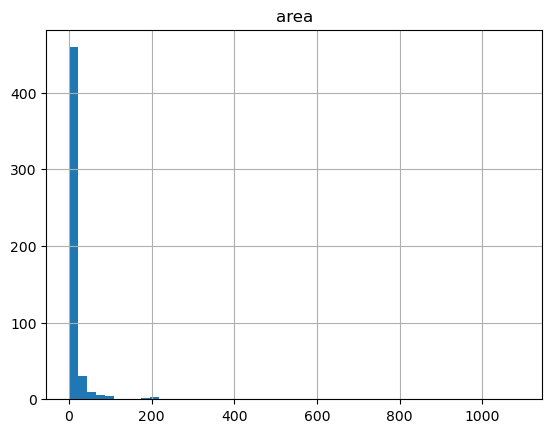

In [11]:
fires.hist("area", bins=50)

In [12]:
fires["log_area"] = np.log1p(fires['area'])
fires["log_area"]

0      0.000000
1      0.000000
2      0.000000
3      0.000000
4      0.000000
         ...   
512    2.006871
513    4.012592
514    2.498152
515    0.000000
516    0.000000
Name: log_area, Length: 517, dtype: float64

array([[<AxesSubplot:title={'center':'log_area'}>]], dtype=object)

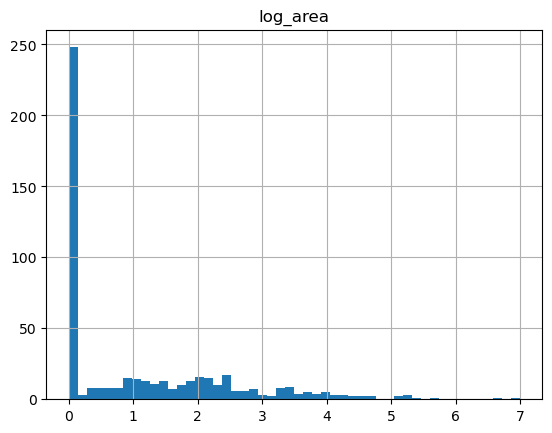

In [13]:
fires.hist("log_area", bins=50)

With the log transformation we can see there was a better distribution of the values. However nearly half the cases, 250, are days where there was no area burnt.

The month and day column provide valuable time information about the fires. In the month case the months in the summer are normally the hotter months in Portugal, but october sometimes still have fires.
In the case of the day, we may need to see if weekends have a higher relevance in the fires.

In [14]:
is_summer = lambda m: 1 if m in ["jun", "jul", "aug", "sept"] else 0
fires["summer"] = [is_summer(m) for m in fires["month"]]

In [15]:
fires["summer"]

0      0
1      0
2      0
3      0
4      0
      ..
512    1
513    1
514    1
515    1
516    0
Name: summer, Length: 517, dtype: int64

In [16]:
is_weekend = lambda d: 1 if d in ["sat", "sun"] else 0
fires["weekend"] = [is_weekend(d) for d in fires["day"]]

In [17]:
fires["weekend"]

0      0
1      0
2      1
3      0
4      1
      ..
512    1
513    1
514    1
515    1
516    0
Name: weekend, Length: 517, dtype: int64

Considering the number of missing cases in some variables, 45, we can use the KNN inputer to fill te missing values in all the collumns where these were detected.

In [18]:
from sklearn.impute import KNNImputer

imp = KNNImputer(missing_values=np.nan, n_neighbors=3)
fires_missing = fires[["FFMC", "DMC", "DC", "ISI", "temp", "RH", "wind", "rain"]]
imputed = pd.DataFrame(imp.fit_transform(fires_missing), 
                       columns = fires_missing.columns)
imputed

,FFMC,DMC,DC,ISI,temp,RH,wind,rain
0,86.2,26.200000,94.300000,5.1,16.6,51.0,6.700000,0.0
1,90.6,56.433333,669.100000,6.7,18.0,33.0,0.900000,0.0
2,90.6,43.700000,470.833333,6.7,14.6,33.0,1.300000,0.0
3,91.7,33.300000,77.500000,9.0,8.3,97.0,4.000000,0.2
4,89.3,51.300000,102.200000,9.6,11.4,99.0,4.333333,0.0
...,...,...,...,...,...,...,...,...
512,81.6,56.700000,665.600000,1.9,27.8,32.0,2.700000,0.0
513,81.6,56.700000,665.600000,1.9,21.9,71.0,5.800000,0.0
514,81.6,56.700000,665.600000,1.9,21.2,70.0,6.700000,0.0
515,94.4,146.000000,614.700000,11.3,25.6,42.0,4.000000,0.0


Let's now check for outliers in the features:

<AxesSubplot:>

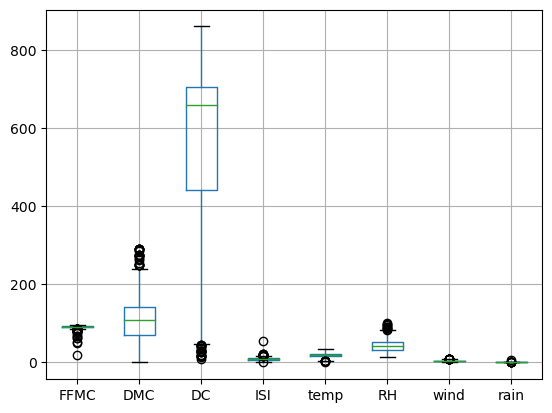

In [19]:
imputed.boxplot()

We can observe there are some outliers, but we need t check if they are significant, by using the quartlis method.

In [20]:
outliers_columns= {}

for col in imputed:
    # quartiles of the variable
    percentiles = [25,50,75]
    quartiles = np.percentile(fires[col], percentiles)
    
    # IQR of the column
    iqr = quartiles[2] - quartiles[0]

    # lower bound and upper bound of a box plot
    lower_bound = quartiles[0] - (1.5 * iqr)
    upper_bound = quartiles[2] + (1.5 * iqr)

    # number of outliers in the column

    outliers = sum((imputed[col] < lower_bound) | (imputed[col] > upper_bound))
    
    outliers_columns[col] = outliers

outliers_columns       

{'FFMC': 0,
 'DMC': 0,
 'DC': 0,
 'ISI': 0,
 'temp': 0,
 'RH': 0,
 'wind': 0,
 'rain': 0}

There seems to be no significant outliers, so we will not remove any from the data set.

We can now standardise the features to be able to compare them in the same magnitude and after that append the summer and weekend columns.

In [21]:
from sklearn.preprocessing import StandardScaler

# Instantiate a StandardScaler() object
scaler = StandardScaler()

# Standardize the X_train data
standardized_imputed = scaler.fit_transform(imputed)

final = pd.concat([fires[["summer", "weekend"]], imputed], axis=1)
final

,summer,weekend,FFMC,DMC,DC,ISI,temp,RH,wind,rain
0,0,0,86.2,26.200000,94.300000,5.1,16.6,51.0,6.700000,0.0
1,0,0,90.6,56.433333,669.100000,6.7,18.0,33.0,0.900000,0.0
2,0,1,90.6,43.700000,470.833333,6.7,14.6,33.0,1.300000,0.0
3,0,0,91.7,33.300000,77.500000,9.0,8.3,97.0,4.000000,0.2
4,0,1,89.3,51.300000,102.200000,9.6,11.4,99.0,4.333333,0.0
...,...,...,...,...,...,...,...,...,...,...
512,1,1,81.6,56.700000,665.600000,1.9,27.8,32.0,2.700000,0.0
513,1,1,81.6,56.700000,665.600000,1.9,21.9,71.0,5.800000,0.0
514,1,1,81.6,56.700000,665.600000,1.9,21.2,70.0,6.700000,0.0
515,1,1,94.4,146.000000,614.700000,11.3,25.6,42.0,4.000000,0.0


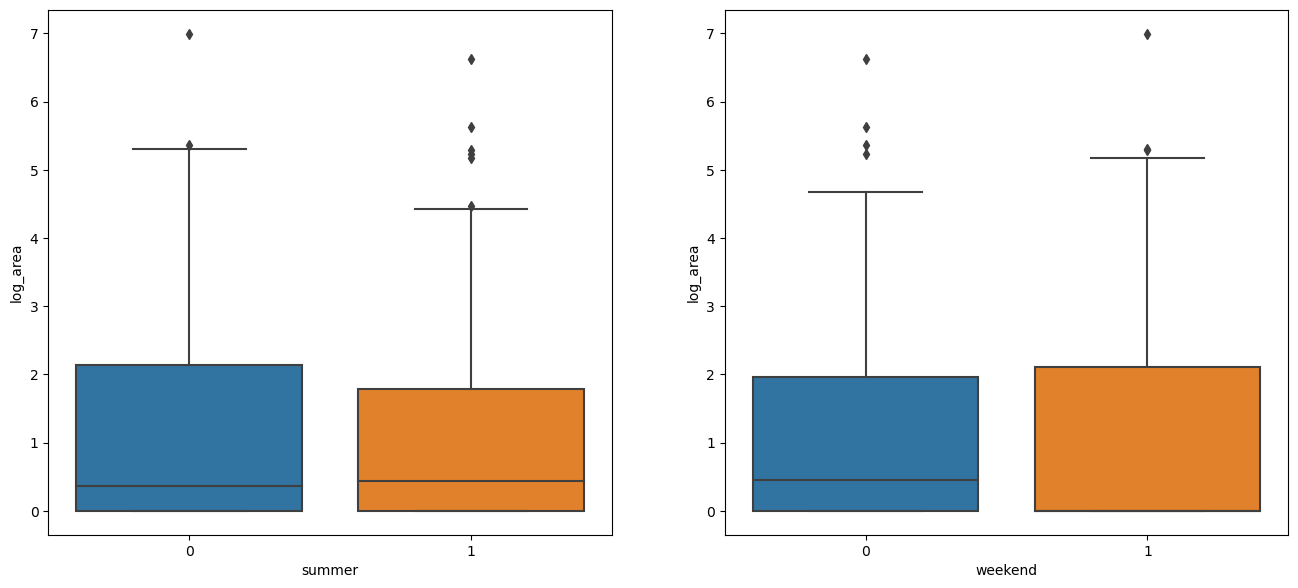

In [22]:
fig = plt.figure(figsize=(16,15))

categorical_cols = ["summer", "weekend"]

for idx, col in enumerate(categorical_cols):
    ax = plt.subplot(2, 2, idx+1)
    # group by HeartDisease
    sns.boxplot(x=final[col], y=fires["log_area"], ax=ax)
    # add data labels to each bar
    for container in ax.containers:
        ax.bar_label(container, label_type="center")

In [23]:
fires["log_area"].groupby(fires["weekend"]).describe()


,count,mean,std,min,25%,50%,75%,max
weekend,,,,,,,,
0,338.0,1.078681,1.334612,0.0,0.0,0.457245,1.957973,6.61644
1,179.0,1.172101,1.513645,0.0,0.0,0.000000,2.113186,6.99562


We can see that the median in the summer months is higher and also that the fires are mostly occoring at week days.

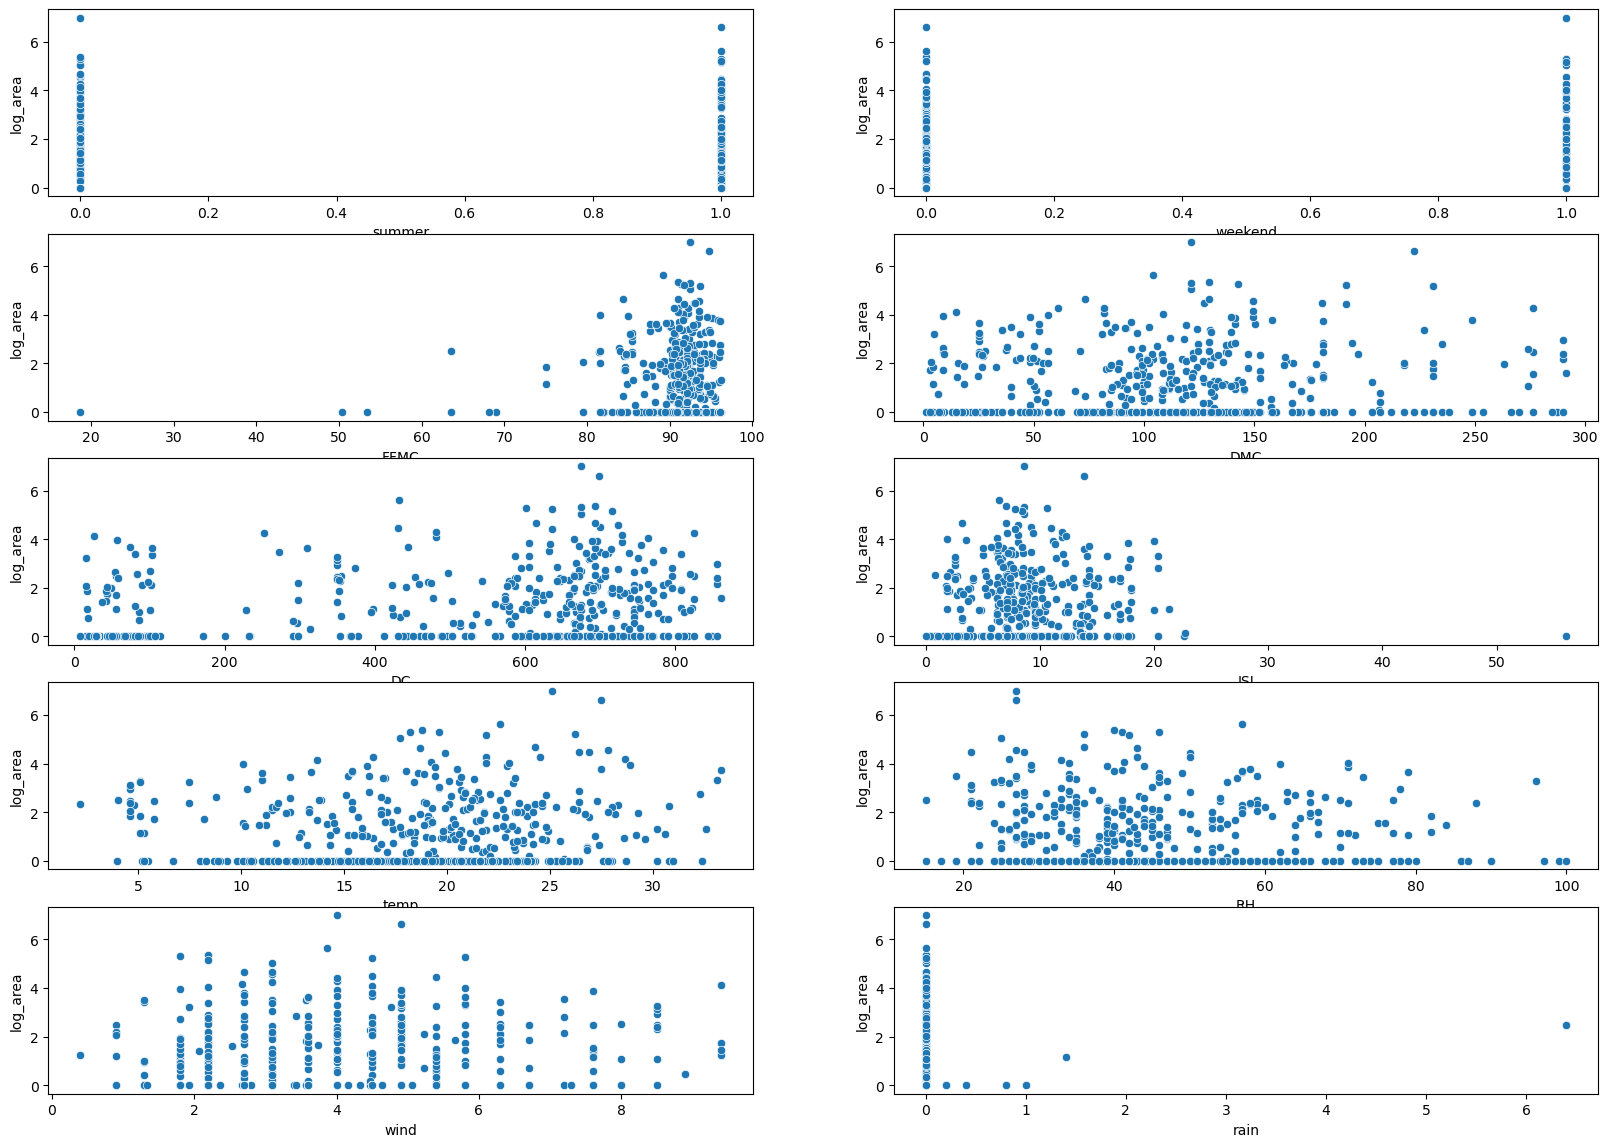

In [24]:
fig = plt.figure(figsize=(20,17))

numerical_cols = final.columns

for idx, col in enumerate(numerical_cols):
    ax = plt.subplot(6, 2, idx+1)
    # group by HeartDisease
    sns.scatterplot(x=final[col], y=fires["log_area"], ax=ax)
    # add data labels to each bar
    #for container in ax.containers:
        #ax.bar_label(container, label_type="center")

These visualisations show that the higher the FMMC, the higher the burnt area. The DMC variable is more distributed, with most of the highest burnt areas appear over 100 and most fires are concentrated in the 75 to 100 DMC. The variation of the burnt area with the DC, shows two zones one bellow 200 and another over 400, with the highest burnt areas within the 700 DC. The ISI shows a higher burtn arear around 10. The humidity chart clearly shows a higher burnt area with lower levels of RH. The wind seems to have some imfluence, but the wind speed over the average does not seem to increase the burnt area.The rain was only high on 6 days when low areas of forest where burnt.
We can also observe there are mostly non-linear relationships with the target variable.

Let's see the correlation between variables, including the target variable:

In [25]:
final_wtarget = pd.concat([final, fires["log_area"]], axis=1)
final_wtarget

,summer,weekend,FFMC,DMC,DC,ISI,temp,RH,wind,rain,log_area
0,0,0,86.2,26.200000,94.300000,5.1,16.6,51.0,6.700000,0.0,0.000000
1,0,0,90.6,56.433333,669.100000,6.7,18.0,33.0,0.900000,0.0,0.000000
2,0,1,90.6,43.700000,470.833333,6.7,14.6,33.0,1.300000,0.0,0.000000
3,0,0,91.7,33.300000,77.500000,9.0,8.3,97.0,4.000000,0.2,0.000000
4,0,1,89.3,51.300000,102.200000,9.6,11.4,99.0,4.333333,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
512,1,1,81.6,56.700000,665.600000,1.9,27.8,32.0,2.700000,0.0,2.006871
513,1,1,81.6,56.700000,665.600000,1.9,21.9,71.0,5.800000,0.0,4.012592
514,1,1,81.6,56.700000,665.600000,1.9,21.2,70.0,6.700000,0.0,2.498152
515,1,1,94.4,146.000000,614.700000,11.3,25.6,42.0,4.000000,0.0,0.000000


<AxesSubplot:>

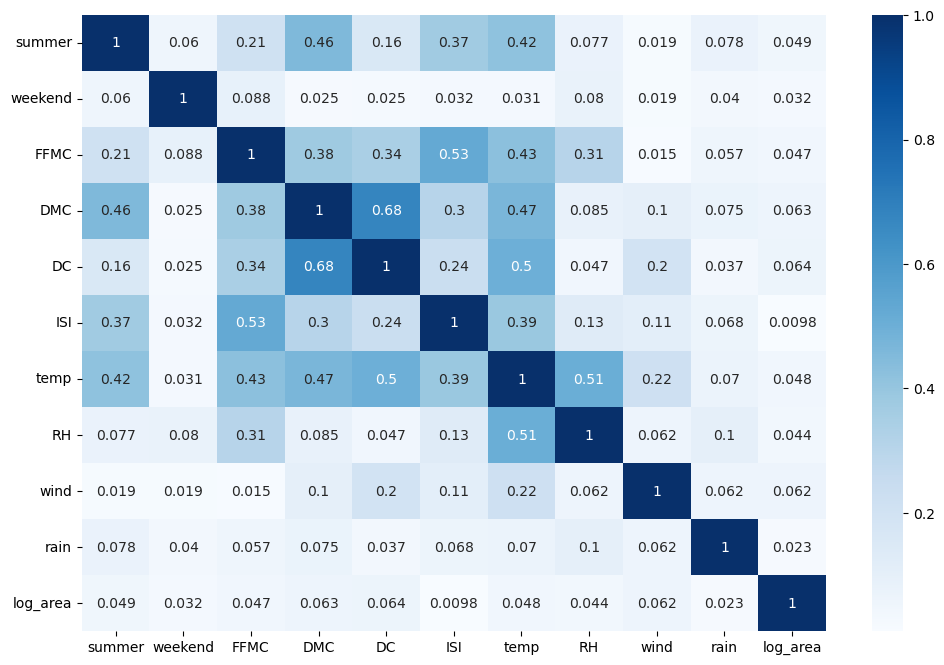

In [26]:
correlations = abs(final_wtarget.corr())
plt.figure(figsize=(12,8))
sns.heatmap(correlations, annot=True, cmap="Blues")

We can observe that the log target value doesn't have significant linear correlations with any of the scaled features, as we would expect given the visualizations. We can also observe that the summer variable is highly correlated with th FSI variables, while the weekend variable doesn't seem significant.
Let's see the unscaled variables.

<AxesSubplot:>

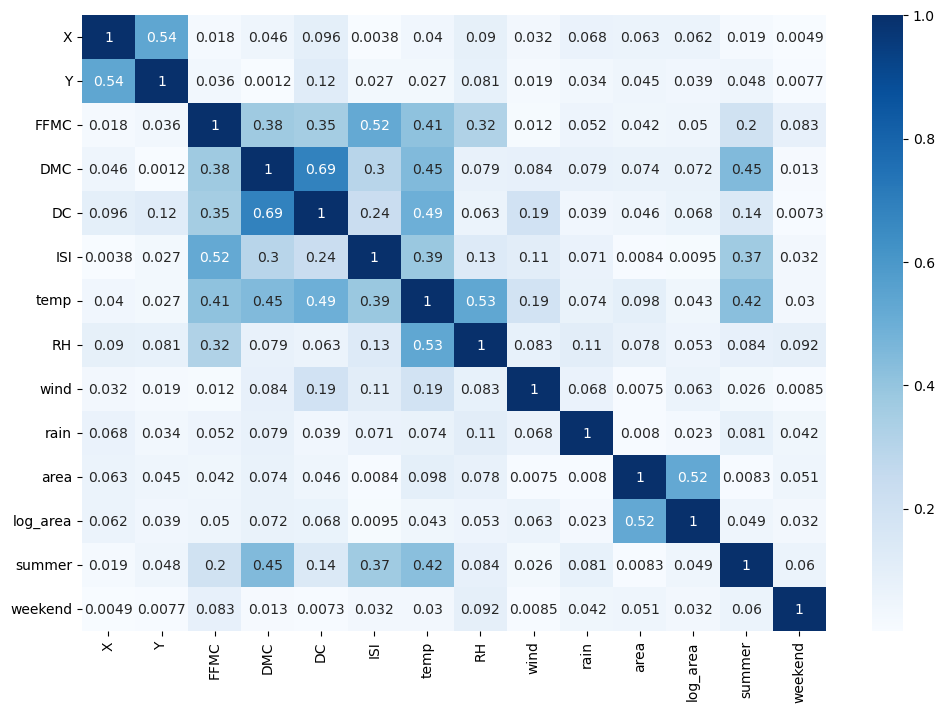

In [27]:
correlations = abs(fires.corr())
plt.figure(figsize=(12,8))
sns.heatmap(correlations, annot=True, cmap="Blues")

The results are similar. We need to use other methods to find the optimal features to use in the model.

## Subset Selection 

Now that we have a cleaned dataset with all numerical features and we've visually explored feature-outcome relationships, we can start modeling. There are quite a few features in the dataset, so let's use feature selection to determine which features might be useful for generating predictions. This is a purely data-driven approach to choosing a model based on feature importance, so it can help inform our process for creating an intial model that we can improve upon.

First we will perform sequential feature selection on the features in the dataset. We will repeat the process using a different number of features upon which to end the selection. We will try both forward and backward selection. By examining the results of the selection, we will see which features seem to have the greatest effect. 


In [28]:
y = fires["log_area"]

In [29]:
# We calculate the AIC like this:

def AIC(p, n, SSE):
    return 2 * p + 2 * n * np.log(SSE)


Forward Selection

In [30]:
# Create a LinearRegression() model, and assign it to the variables models for 
# 2, 4 and 6 features

model = LinearRegression()

# Create a SequentialFeatureSelector() object, and specify that we want 
# a final model with 2, 4 and6 features using forward selection
forward2 = SequentialFeatureSelector(estimator=model,
                                    n_features_to_select=2,
                                    direction="forward")
forward4 = SequentialFeatureSelector(estimator=model,
                                    n_features_to_select=4,
                                    direction="forward")
forward6 = SequentialFeatureSelector(estimator=model,
                                    n_features_to_select=6,
                                    direction="forward")

#Fit the forward models using the given final and y datasets
forward2.fit(final,y)
forward4.fit(final,y)
forward6.fit(final,y)

# Get the names of the features used in the resulting model, 
# and assign it to the variables forward_features
forward_features2 = forward2.get_feature_names_out()
forward_features4 = forward4.get_feature_names_out()
forward_features6 = forward6.get_feature_names_out()

print(forward_features2)
print(forward_features4)
print(forward_features6)

['weekend' 'FFMC']
['weekend' 'FFMC' 'DC' 'wind']
['weekend' 'FFMC' 'DC' 'ISI' 'RH' 'wind']


Backward Selection

In [31]:
# Create a SequentialFeatureSelector() object, and specify that we want 
# a final model with 2, 4 and 6 features using backward selection
backward2 = SequentialFeatureSelector(estimator=model,
                                    n_features_to_select=2,
                                    direction="backward")
backward4 = SequentialFeatureSelector(estimator=model,
                                    n_features_to_select=4,
                                    direction="backward")
backward6 = SequentialFeatureSelector(estimator=model,
                                    n_features_to_select=6,
                                    direction="backward")

#Fit the backward models using the given final and y datasets
backward2.fit(final,y)
backward4.fit(final,y)
backward6.fit(final,y)

#Get the names of the features used in the resulting model, 
# and assign it to the variables forward_features
backward_features2 = backward2.get_feature_names_out()
backward_features4 = backward4.get_feature_names_out()
backward_features6 = backward6.get_feature_names_out()

print(backward_features2)
print(backward_features4)
print(backward_features6)

['weekend' 'DC']
['weekend' 'FFMC' 'DC' 'wind']
['weekend' 'FFMC' 'DC' 'ISI' 'RH' 'wind']


The results from the sub sets show that the most common features are Weekend, DC and FMMC.

Now that we have the features chosen by , let's actually create the models and compare:

In [32]:
# Using forward and backward selections, create subsets of Final(X) that only contain those features. Name these DataFrames X2 and X5 respectively.
final_forward2 = final[forward_features2]
final_forward4 = final[forward_features4]
final_forward6 = final[forward_features6]

final_backward2 = final[backward_features2]
final_backward4 = final[backward_features4]
final_backward6 = final[backward_features6]

# Create 6 new LinearRegression() objects
fw2 = LinearRegression()
fw4 = LinearRegression()
fw6 = LinearRegression()

bk2 = LinearRegression()
bk4 = LinearRegression()
bk6 = LinearRegression()

# Fit these models using the Final subsets datasets we made earlier
fw2.fit(final_forward2, y)
fw4.fit(final_forward4, y)
fw6.fit(final_forward6, y)

bk2.fit(final_backward2, y)
bk4.fit(final_backward4, y)
bk6.fit(final_backward6, y)

# Get the total number of observations in Final(X) and assign it to the variable 

n = final.shape[0]
# Calculate the MSE for all models and multiply both of these values by n to get the sum of squared errors (SSE) for both models. 
yf2 = fw2.predict(final_forward2)
yf4 = fw4.predict(final_forward4)
yf6 = fw6.predict(final_forward6)

yb2 = bk2.predict(final_backward2)
yb4 = bk4.predict(final_backward4)
yb6 = bk6.predict(final_backward6)

sse_f2 = mean_squared_error(y,yf2)*n
sse_f4 = mean_squared_error(y,yf4)*n
sse_f6 = mean_squared_error(y,yf6)*n

sse_b2 = mean_squared_error(y,yb2)*n
sse_b4 = mean_squared_error(y,yb4)*n
sse_b6 = mean_squared_error(y,yb6)*n

# Finally, calculate the AIC for all models using the value of n and the SSEs we calculated above

aic_f2 = AIC(2, n, sse_f2)
aic_f4 = AIC(2, n, sse_f4)
aic_f6 = AIC(2, n, sse_f6)

aic_b2 = AIC(2, n, sse_b2)
aic_b4 = AIC(2, n, sse_b4)
aic_b6 = AIC(2, n, sse_b6)

print(aic_f2)
print(aic_f4)
print(aic_f6)
print(aic_b2)
print(aic_b4)
print(aic_b6)

print(min([aic_f2, aic_f4, aic_f6, aic_b2, aic_b4, aic_b6]))

7152.374289230907
7143.653371874133
7138.449791315442
7150.542495416046
7143.653371874133
7138.449791315442
7138.449791315442


The feature selection with the smallest AIC is the backward selection with 6 features.

## Developing Candidate Models

The models chosen by subset selection are still linear models at heart, and they may not be the best solution to this problem. Despite their widespread utility, some problems have a non-linear component that standard linear regression models can't account for.
Some of the more flexible models that we've learned about as candidate models: polynomials and splines, comes at a price: an increased chance of overfitting. Including higher polynomials, more knots, or many features in the model may help with predictive ability on the training set, but we may be setting ourselves up for poor performance on the test set. In the case of many features, we can also turn to regularization to account for this. 

Regularization is the process of simplifying a model. Simplifying a model helps us overcome high-dimesional issues because it allows us to discard features that don't contribute to the model's predictive ability. In this point, we'll use regularization in the context of linear models, with the Ridge regression and LASSO models.

In [33]:
# Create a RidgeCV() ans LassoCV() objects, and assign it to the variables initials
ridge_initial = RidgeCV(alphas=np.linspace(10, 1000, num=100))
lasso_initial = LassoCV(alphas=np.linspace(10, 10000, num=1000))

# Fit the initials using the Final and y datasets.
ridge_initial.fit(final, y)
lasso_initial.fit(final, y)

# Assign the coefficient values of the models to the variables 
ridge_initial_coef = ridge_initial.coef_
lasso_initial_coef = lasso_initial.coef_

# Assign the α value used by ridge_initial to the variable alpha_initial
alpha_initial = ridge_initial.alpha_
lasso_initial = lasso_initial.alpha_

print("Ridge coeficients: ", ridge_initial_coef)
print("Lasso coeficients: ", lasso_initial_coef )
print("Ridge Alpha: ", alpha_initial)
print("Lasso Alpha: ", lasso_initial)

Ridge coeficients:  [-0.05504635  0.02889359  0.00799818  0.0012281   0.00021869 -0.0193707
  0.00422918 -0.00355493  0.05855663  0.01162394]
Lasso coeficients:  [-0.  0.  0.  0.  0. -0.  0. -0.  0.  0.]
Ridge Alpha:  330.0
Lasso Alpha:  10000.0


The Ridge coeficients seem to be small, and the Lasso model indicates that none of the features is better.
Concentrating on the Ridge model only, we can further tune th alpha parameter.

In [34]:
ridge_tuning = RidgeCV(alphas=np.linspace(10, 400, num=10))
ridge_tuning.fit(final, y)
ridge_tuned_alpha = ridge_tuning.alpha_
print("Ridge tuned parameter: ", ridge_tuning.alpha_)

Ridge tuned parameter:  313.33333333333337


In [35]:
# New ridge model
ridge = RidgeCV(alphas=ridge_tuning.alpha_)
ridge.fit(final, y)
y_ridge = ridge.predict(final)

# Calculate the AIC 
sse_ridge = mean_squared_error(y,y_ridge)*n
aic_ridge = AIC(2, n, sse_ridge)

print(aic_ridge)

7135.81690671839


Comparing all the models we can see that the ridge model has the lower AIC, followed by the backward sequential feature selection wit 6 features.

Both polynomial and spline models extend standard linear models by incorporating functions of features in the model instead of the raw features themselves. The resulting model is still linear in nature, so we can use the LinearRegression class to estimate the coefficients needed to complete the model. 
Splines are actually piecewise polynomial models with added constraints to make the resulting function look smooth at the knots. While we can adjust both the degree of the polynomials used in the spline and the number of knots, it's often a best practice to use a lower-degree polynomial and increase the number of knots via cross-validation.

Let's check the relationship between the RH and log_area, that we observed in the visualization section, by applying a plynomial model first and a spline later.


In [ ]:
X = final["RH"].values.reshape(-1, 1)

poly = PolynomialFeatures(degree=2, include_bias=False)
quad_X = poly.fit_transform(X)

# Create two LinearRegression() objects:
# One will be assigned to the variable LinearRegression
linear = LinearRegression()
quadratic = LinearRegression()

# Fit the linear model on the data that has not been transformed, and fit the quadratic model on the data that has been transformed. 
linear.fit(X, y)
quadratic.fit(quad_X, y)

y_pred_lin = linear.predict(X)
y_pred_quad = quadratic.predict(quad_X)

# Calculate the MSEs for both models. Assign the linear model MSE to linear_mse and the quadratic model MSE to quadratic_mse
linear_mse = mean_squared_error(y, y_pred_lin)
quadratic_mse = mean_squared_error(y, y_pred_lin)

# Compare the two MSEs to determine which model performs better on the test set. 

if (linear_mse < quadratic_mse): 
    better_model = "linear"
better_model = "quadratic"

print(linear_mse)
print(quadratic_mse) 
print(better_model)                                   

plt.figure(figsize=(10,6))
plt.scatter(X,y)
#plt.plot(X, y_pred_lin, c="red")
plt.plot(X, y_pred_quad, c="blue")
plt.show()

In [66]:
# Rough cross-validation exercise to optimize the number of knots in spline

# Create an empty list called test_mses
test_mses = []

# Iterate over the integers ranging from 2 to 10 (inclusive),

for n in range(2, 11):
    # Create a SplineTransformer() object where the n_knots parameter is set to the current iteration number
    spline = SplineTransformer(n_knots=n)
    # fit and transform the X dataset.
    spline_X = spline.fit_transform(X)
    # Create a LinearRegression() object, and fit it to the transformed dataset
    model = LinearRegression()
    model.fit(spline_X, y)
    # Using the fitted model, calculate the test MSE for that particular number of knots
    mse = mean_squared_error(y, model.predict(spline_X))
    test_mses.append(round(mse))

# test_mses = list(np.round(test_mses, 0))

# Based on the test MSEs, what would be the optimal number of knots to use?
print(test_mses)

optimal_knots = test_mses.index(min(test_mses))+2
print(optimal_knots)



[2, 2, 2, 2, 2, 2, 2, 2, 2]
2


In [ ]:
# Create a SplineTransformer() object where the n_knots parameter is set to the current iteration number
spline = SplineTransformer(n_knots=2)
# fit and transform the X dataset.
spline_X = spline.fit_transform(X)
# Create a LinearRegression() object, and fit it to the transformed dataset
model = LinearRegression()
model.fit(spline_X, y)
# Using the fitted model, calculate the test MSE for that particular number of knots
y_pred_spline = model.predict(spline_X)
mse = mean_squared_error(y, y_pred_spline)
mse

plt.figure(figsize=(10,6))
plt.scatter(X,y)
plt.plot(X, y_pred_spline, c="blue")
plt.show()

## K-Fold Cross-Validation

Let's use K-fold cross validation. The dataset will be divided into k folds of equal or approximately equal size. Then one fold will be used as the test set, while the remaining k−1 folds will be used for the training set. With k folds, we'll also get k test MSEs, which means we can calculate not only their average but also their standard deviation. While k is generally considered arbitrary, a general rule is to use k=5 or k=10. We will use K=5, using all the models defined before and the reference model considered in the beginning of the analysis.

In [36]:
reference_cv = cross_val_score(reference, final[["wind", "temp"]], y, cv=5,scoring="neg_mean_squared_error")
fw2_cv = cross_val_score(fw2, final, yf2, cv=5, scoring="neg_mean_squared_error")
fw4_cv = cross_val_score(fw4, final, yf4, cv=5, scoring="neg_mean_squared_error")
fw6_cv = cross_val_score(fw6, final, yf6, cv=5, scoring="neg_mean_squared_error")

bk2_cv = cross_val_score(bk2, final, yb2, cv=5, scoring="neg_mean_squared_error")
bk4_cv = cross_val_score(bk4, final, yb4, cv=5, scoring="neg_mean_squared_error")
bk6_cv = cross_val_score(bk6, final, yb6, cv=5, scoring="neg_mean_squared_error")

ridge_cv = cross_val_score(ridge, final, y_ridge, cv=5, scoring="neg_mean_squared_error")

In [37]:
print("Reference Model, Avg Test MSE: ", np.mean(reference_cv), " SD: ", np.std(reference_cv))
print("Forward-2 Model, Avg Test MSE: ", np.mean(fw2_cv), " SD: ", np.std(fw2_cv))
print("Forward-4 Model, Avg Test MSE: ", np.mean(fw4_cv), " SD: ", np.std(fw4_cv))
print("Forward-6 Model, Avg Test MSE: ", np.mean(fw6_cv), " SD: ", np.std(fw6_cv))
print("Backward-2 Model, Avg Test MSE: ", np.mean(bk2_cv), " SD: ", np.std(bk2_cv))
print("Backward-4 Model, Avg Test MSE: ", np.mean(bk4_cv), " SD: ", np.std(bk4_cv))
print("Backward-6 Model, Avg Test MSE: ", np.mean(bk6_cv), " SD: ", np.std(bk6_cv))
print("Ridge Model, Avg Test MSE: ", np.mean(ridge_cv), " SD: ", np.std(ridge_cv))

Reference Model, Avg Test MSE:  -2.2046500130041156  SD:  1.060040355378637
Forward-2 Model, Avg Test MSE:  -6.721348105388151e-30  SD:  4.0725505462721195e-30
Forward-4 Model, Avg Test MSE:  -1.9528465226631423e-29  SD:  2.0058517125309055e-29
Forward-6 Model, Avg Test MSE:  -8.78597578613035e-30  SD:  3.743261765701098e-30
Backward-2 Model, Avg Test MSE:  -1.2358872244949955e-29  SD:  9.669349301516615e-30
Backward-4 Model, Avg Test MSE:  -1.9528465226631423e-29  SD:  2.0058517125309055e-29
Backward-6 Model, Avg Test MSE:  -8.78597578613035e-30  SD:  3.743261765701098e-30
Ridge Model, Avg Test MSE:  -0.0009926589747573655  SD:  4.522991853344127e-05


We can see that the Ridge model shows a low MSE, since it reduces the coeficients closer to zero, and has done a good job. The next best model is the linear regression with the 2 features selected by the backward sequential feature selection model, with an order of magnitude of error, since we are dealing with a logaritimic scale.

# Examining Model Weaknesses

Now that we've created many candidate models, we can choose the best and start to determine where our data might be lacking. To do this, we need to visualize how the model predictions compare against the actual observed values in the data. It may be the case that our model performs well on a particular subset of outcomes but poorly on another subset. The only way to know this is to visualize these differences. Let's visualize our model performance.

Our best performing model was the ridge regression model. Let's calculate the predicted values.

In [ ]:
y_ridge

In [74]:
residuals = y - y_pred
residuals

0     -1.089088
1     -0.982294
2     -0.962232
3     -0.706526
4     -0.757036
         ...   
512    0.878490
513    2.864376
514    1.296232
515   -1.179655
516   -1.006480
Name: log_area, Length: 517, dtype: float64

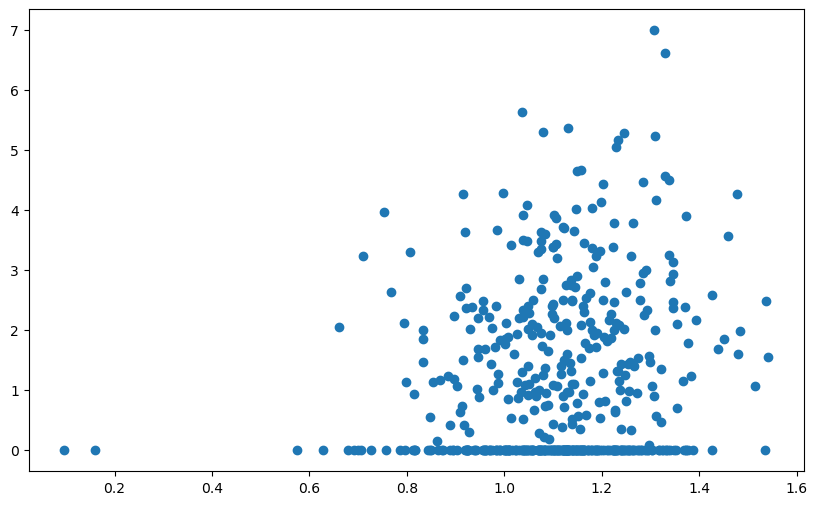

In [75]:
plt.figure(figsize=(10,6))
plt.scatter(y_pred, y)
plt.show()

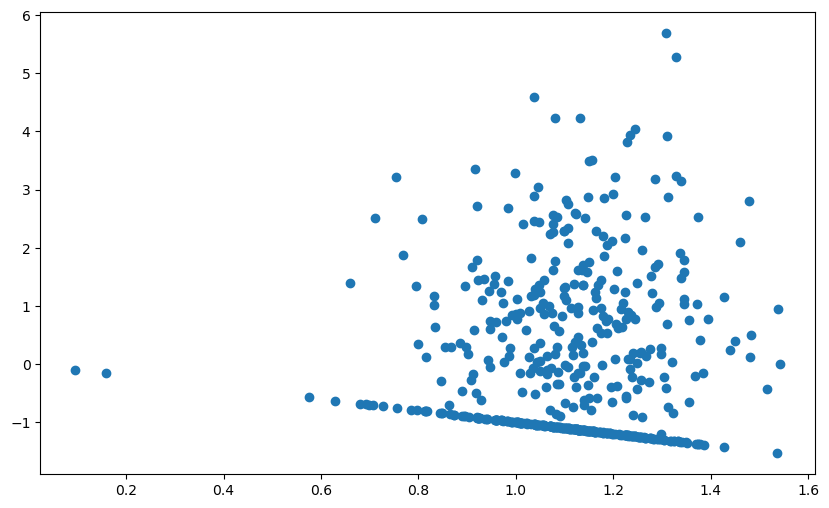

In [73]:
plt.figure(figsize=(10,6))
plt.scatter(y_pred, residuals)
plt.show()

We can observe from both visualisations that the models are not predicting the days where ther was no burnt areas, and also the days where the areas of forest burned where high. This kind of problems seem to be diffiult to obtein a high performance model, given the characteristics of the data set.